# Project :  charge-off and risk

### Muhammad Tahir @ Colorado State University

### Remarks:
#### I enjoyed learning a lot of new business questions. There are a lot of interesting things to explore further if I have a large memory and more time.
#### I want to try piple-line using Naive Bayes, Ridge and elasticnet etc. Also I need to do feature engineering (interaction, groupby etc) and parameter tuning.

#### Data is clearly imbalanced and our business interests need clarity like what we want to achieve; either precision or recall and similarly F1-score is affected.
#### I tried class_weight={0:1, 1:6} to see how true positive training and tests are. This provides improvement. I did this keeping in mind that 'is_charged_off' (1) compared to 0 shows a difference of 6-time.


## Imports and Data Extraction

In [1]:
# Required Imports 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import train_test_split.
from sklearn.model_selection import train_test_split, cross_val_score

# Import logistic regression
from sklearn.linear_model import LogisticRegression

# Import metrics.
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix,
    accuracy_score, plot_roc_curve, roc_auc_score, recall_score,
    precision_score, f1_score)

In [2]:
# Reading data; df
df = pd.read_csv('LoanStats_2015_subset.csv')


/Users/tahir/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (14,24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
#checking first five rows and column names of 
df.head()

,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,...,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
0,0.0,8.0,KS,42.0,65000.0,NaN,Individual,10086.0,41055.0,17.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,1.0,VT,34.0,150000.0,NaN,Individual,61551.0,24661.0,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,8.0,IN,50.0,75000.0,NaN,Individual,7176.0,23476.0,59.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,7.0,OH,71.0,175000.0,NaN,Individual,51015.0,21569.0,50.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1.0,FL,91.0,44000.0,NaN,Individual,19041.0,0.0,102.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Section A - KPI Reporting

### 1) What is the monthly total loan volume in dollars and what is the monthly average loan size?

In [4]:
#first we need to see null values in the installment columns to find loan
df.installment.isnull().sum()

2

In [5]:
#loan column is
df_loan = df['installment']
df_loan.head()

0     253.79
1     752.87
2     718.51
3    1051.31
4     465.22
Name: installment, dtype: float64

In [6]:
#droping null values from loan colums
df_loan.dropna(inplace=True)


df_loan.isnull().sum()

0

In [7]:
#monthly total loan volume in dollars
df_loan.sum()

186060586.61

In [8]:
#and what is the monthly average loan size
df_loan.mean()

441.8494320996851

# 2: What are the charge-off rates by Loan Grade ?

In [9]:
# To find charge-off rates, we need loan_status column
# first we need to see if there is any null
df_loan_status = df['loan_status']
df_loan_status.isnull().sum()

2

In [10]:
#we have to to drop null values
df_loan_status.dropna(inplace=True)

df_loan_status.isnull().sum()

0

In [11]:
#Unique values of loan_status
df_loan_status.value_counts()

Fully Paid            196814
Current               151713
Charged Off            63845
Late (31-120 days)      4905
In Grace Period         2757
Late (16-30 days)       1052
Default                    9
Name: loan_status, dtype: int64

In [12]:
#unique values of grade column
df['grade'].value_counts()

C    120567
B    117606
A     73336
D     62654
E     34948
F      9817
G      2167
Name: grade, dtype: int64

In [13]:
# added a new column to find charge off
df['is_charged_off'] = df['loan_status'].apply(lambda x: 1 if x in ['Default','Charged Off'] else 0)

In [14]:
#charge off is group by with grades
df_chrg = df.groupby('grade')['is_charged_off'].value_counts()

In [15]:
# charge off rate is thus
df_rates = df[df['is_charged_off']==1]['grade'].value_counts()/df['grade'].value_counts()

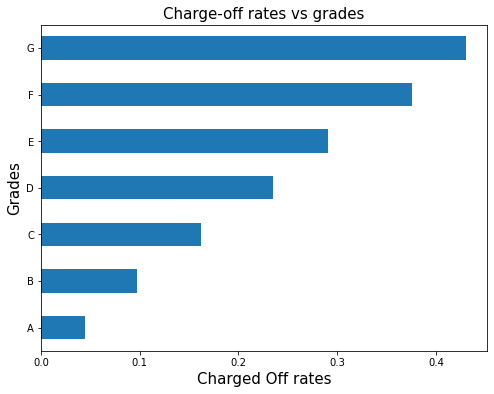

In [16]:
#visual of charge off rates
plt.figure(figsize = (8,6))
df_rates.plot(kind='barh')
plt.xlabel('Charged Off rates', fontsize=15)
plt.ylabel('Grades', fontsize=15)
plt.title('Charge-off rates vs grades', size = 15)
plt.show();

## 3) Are there any statistically significant differences in charge-off rate by Loan Grade? Please explain how you made this determination.

we need to check p-values to see any statistically significant difference

In [17]:
#imports for statistical analysis
from scipy import stats

In [18]:
#charge off is group by with grades
df.groupby('grade')['is_charged_off'].value_counts()

grade  is_charged_off
A      0                  70032
       1                   3304
B      0                 106136
       1                  11470
C      0                 101009
       1                  19558
D      0                  47920
       1                  14734
E      0                  24784
       1                  10164
F      0                   6126
       1                   3691
G      0                   1234
       1                    933
Name: is_charged_off, dtype: int64

In [19]:
#statistical test
stats.chi2_contingency([[3304, 11470, 19558, 14734, 10164, 3691, 933], [70032, 106136, 101009, 47920, 24784, 6126, 1234]])

(23070.162985068,
 0.0,
 6,
 array([[ 11120.5237393 ,  17833.53761978,  18282.53771239,
           9500.72671487,   5299.44452439,   1488.63016184,
            328.59952742],
        [ 62215.4762607 ,  99772.46238022, 102284.46228761,
          53153.27328513,  29648.55547561,   8328.36983816,
           1838.40047258]]))

#second line in above result is p-value

from p-values we know this is less than threshold of 5% or 1%. Therefore, we can confidently say that
there are statistically significant differences here since p-value is less than threshold and particularly zero.

we may try fisher test but not recommended for large number. we prefer chi due to large data. data is independent
assumptions of chi test:
independent

## 4) Is Lending Club charging an appropriate interest rate for the risk?

In [20]:
#checking interest rate column
df['int_rate'].isnull().sum()

2

In [21]:
#consider data frame
df_int_rate = df['int_rate']

In [22]:
# drop missing values
df_int_rate.dropna(inplace=True)


df_int_rate.isnull().sum()

0

In [23]:
#final dataframe of interest rate column
df_int_rate=df_int_rate.str.replace('%', '').astype(float)

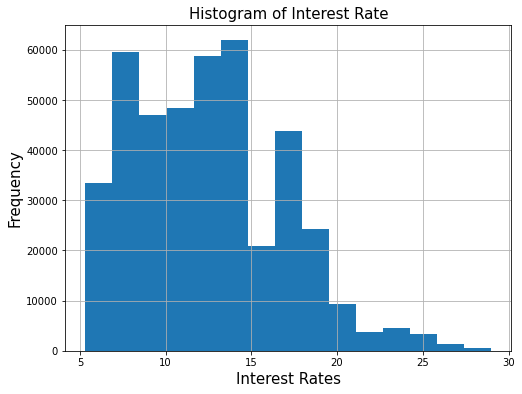

In [24]:
#visual of interest rates
plt.figure(figsize = (8,6))
df_int_rate.hist(bins=15)
plt.xlabel('Interest Rates', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Histogram of Interest Rate', size = 15)
plt.show();

In [25]:
#statistics of interest rate
df_int_rate.describe()

count    421095.000000
mean         12.599697
std           4.318625
min           5.320000
25%           9.170000
50%          12.290000
75%          15.590000
max          28.990000
Name: int_rate, dtype: float64

In [26]:
#chanigning dtypes of interest rate column
df['int_rate'] = df['int_rate'].str.replace('%','').astype(float)

In [27]:
#checking interest rate by groupby of grades
df.groupby('grade')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
grade,,,,,,,,
A,73336.0,6.941617,0.880498,5.32,6.24,6.92,7.89,8.19
B,117606.0,10.044305,1.190417,6.00,9.17,9.99,10.99,11.99
C,120567.0,13.298285,0.855452,6.00,12.59,13.33,13.99,14.99
D,62654.0,16.724470,0.872028,6.00,15.61,16.99,17.57,18.49
E,34948.0,19.290423,1.066145,6.00,18.49,18.99,19.99,21.99
F,9817.0,23.614716,1.322799,6.00,22.99,23.99,24.50,26.06
G,2167.0,26.835187,0.975360,25.80,25.89,26.77,27.31,28.99


In [28]:
#give a temperary name
temp = df.groupby('grade')['int_rate'].describe()['mean']

In [29]:
#checking values
temp

grade
A     6.941617
B    10.044305
C    13.298285
D    16.724470
E    19.290423
F    23.614716
G    26.835187
Name: mean, dtype: float64

In [30]:
#charge off rate is printed again as
df_rates

A    0.045053
B    0.097529
C    0.162217
D    0.235165
E    0.290832
F    0.375980
G    0.430549
Name: grade, dtype: float64

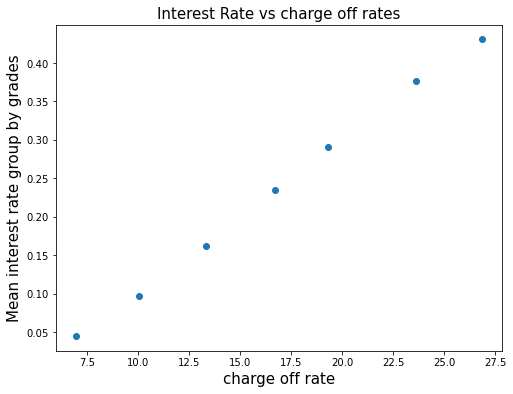

In [31]:
#visual of interest rates
plt.figure(figsize = (8,6))
plt.scatter(temp.values, df_rates.values)
plt.xlabel('charge off rate', fontsize=15)
plt.ylabel('Mean interest rate group by grades', fontsize=15)
plt.title('Interest Rate vs charge off rates', size = 15)
plt.show();

if we assume 15% acceptable then higher values are of risk for grades D, E, F and G. they seems at high risk

Does risk mean higher charge-off rate ?
we can look at the charge-off rates in different loan grades, 
given the interest rate thershold we can determine if it is an appropriate or not ?

## Section B - Modeling
Prior to creating a model, it is important to inspect the quality of the dataset:
1) Data is often messy, please review and clean the Lending Club dataset and summarize your
thoughts on any structural issues:


### a) Is there missing data? Is the missing data random or structured? Are some attributes missing more than others?


Yes, there is missing data here:
1) Structured missing: 1/3 is almost missing more than 60%, which I am going to drop anyway. Because even if i am going impute by any method, it may not predict anything useful.

2) Couple of columns have missing values around 50% of the data and I am going drop.

3) sec_app_ columns: At least 10 columns are with zero non-null values.

4) 50% of our data is with least missing values.

In [32]:
df.shape

(421097, 106)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421097 entries, 0 to 421096
Columns: 106 entries, acc_now_delinq to is_charged_off
dtypes: float64(86), int64(1), object(19)
memory usage: 340.5+ MB


In [34]:
df.isnull().sum().sort_values(ascending=False).head(35)

member_id                              421097
sec_app_open_acc                       421097
revol_bal_joint                        421097
sec_app_earliest_cr_line               421097
sec_app_inq_last_6mths                 421097
sec_app_mort_acc                       421097
sec_app_mths_since_last_major_derog    421097
sec_app_revol_util                     421097
sec_app_open_act_il                    421097
sec_app_num_rev_accts                  421097
sec_app_chargeoff_within_12_mths       421097
sec_app_collections_12_mths_ex_med     421097
id                                     421095
desc                                   421052
dti_joint                              420588
annual_inc_joint                       420586
il_util                                402480
mths_since_rcnt_il                     400287
inq_fi                                 399725
inq_last_12m                           399725
open_acc_6m                            399725
open_il_12m                       

In [35]:
len(df)

421097

In [36]:
# Find how many missing values and percentage missing in each column
#print(f"Missing data in each df dataframe column:"
#for c in df.columns:
    
#    missing_data = len(df) - df[c].count()
#    if (missing_data > 10 or missing_data =='NaN'):
#        #print(c)
#        print(f" {c}: missing values are {(round(float(missing_data / float(len(df))) * 100))}% of total")

In [37]:
indx = df.isnull().sum().sort_values().index
df1 = df[indx]

In [38]:
for i,c in enumerate(df1.columns):
    
    missing_data = len(df1) - df1[c].count()
    missing_rate = (round(float(missing_data / float(len(df1))) * 100))
    if missing_rate >50:
        #print(c)
        print(f" {i}, {c}: missing values are {missing_rate}% of total")

 72, mths_since_recent_revol_delinq: missing values are 64% of total
 73, mths_since_last_major_derog: missing values are 71% of total
 74, mths_since_recent_bc_dlq: missing values are 74% of total
 75, mths_since_last_record: missing values are 82% of total
 76, total_bal_il: missing values are 95% of total
 77, all_util: missing values are 95% of total
 78, total_cu_tl: missing values are 95% of total
 79, open_rv_24m: missing values are 95% of total
 80, max_bal_bc: missing values are 95% of total
 81, open_rv_12m: missing values are 95% of total
 82, open_act_il: missing values are 95% of total
 83, open_il_24m: missing values are 95% of total
 84, open_il_12m: missing values are 95% of total
 85, open_acc_6m: missing values are 95% of total
 86, inq_last_12m: missing values are 95% of total
 87, inq_fi: missing values are 95% of total
 88, mths_since_rcnt_il: missing values are 95% of total
 89, il_util: missing values are 96% of total
 90, annual_inc_joint: missing values are 100

In [39]:
for i,c in enumerate(df1.columns):
    
    missing_data = len(df1) - df1[c].count()
    missing_rate = (round(float(missing_data / float(len(df1))) * 100))
    if missing_rate <50:
        #print(c)
        print(f" {i}, {c}: missing values are {missing_rate}% of total")

 0, is_charged_off: missing values are 0% of total
 1, open_acc: missing values are 0% of total
 2, num_tl_op_past_12m: missing values are 0% of total
 3, num_tl_90g_dpd_24m: missing values are 0% of total
 4, num_tl_30dpd: missing values are 0% of total
 5, num_sats: missing values are 0% of total
 6, num_rev_tl_bal_gt_0: missing values are 0% of total
 7, pct_tl_nvr_dlq: missing values are 0% of total
 8, num_op_rev_tl: missing values are 0% of total
 9, num_bc_tl: missing values are 0% of total
 10, num_bc_sats: missing values are 0% of total
 11, num_actv_bc_tl: missing values are 0% of total
 12, num_accts_ever_120_pd: missing values are 0% of total
 13, mort_acc: missing values are 0% of total
 14, mo_sin_rcnt_tl: missing values are 0% of total
 15, num_il_tl: missing values are 0% of total
 16, mo_sin_rcnt_rev_tl_op: missing values are 0% of total
 17, policy_code: missing values are 0% of total
 18, pub_rec_bankruptcies: missing values are 0% of total
 19, zip_code: missing val

In [40]:
df1.head()

,is_charged_off,open_acc,num_tl_op_past_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_sats,num_rev_tl_bal_gt_0,pct_tl_nvr_dlq,num_op_rev_tl,num_bc_tl,...,sec_app_num_rev_accts,sec_app_open_act_il,sec_app_revol_util,sec_app_mths_since_last_major_derog,sec_app_mort_acc,sec_app_inq_last_6mths,sec_app_earliest_cr_line,revol_bal_joint,sec_app_open_acc,member_id
0,0,18.0,3.0,0.0,0.0,18.0,4.0,100.0,11.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,7.0,1.0,0.0,0.0,7.0,1.0,100.0,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,27.0,2.0,0.0,0.0,27.0,20.0,100.0,24.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,9.0,3.0,0.0,0.0,9.0,2.0,95.7,4.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,7.0,0.0,0.0,0.0,7.0,3.0,100.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df2 = df1.iloc[:,0:70]
df2.head()

,is_charged_off,open_acc,num_tl_op_past_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_sats,num_rev_tl_bal_gt_0,pct_tl_nvr_dlq,num_op_rev_tl,num_bc_tl,...,title,revol_util,mths_since_recent_bc,bc_open_to_buy,bc_util,percent_bc_gt_75,mo_sin_old_il_acct,num_tl_120dpd_2m,emp_length,emp_title
0,0,18.0,3.0,0.0,0.0,18.0,4.0,100.0,11.0,10.0,...,Debt consolidation,13.4%,4.0,41055.0,17.1,0.0,127.0,0.0,10+ years,Teacher
1,0,7.0,1.0,0.0,0.0,7.0,1.0,100.0,4.0,3.0,...,Credit card refinancing,42.5%,73.0,24661.0,44.0,0.0,166.0,0.0,1 year,Director
2,0,27.0,2.0,0.0,0.0,27.0,20.0,100.0,24.0,18.0,...,Debt consolidation,51.9%,10.0,23476.0,59.9,50.0,143.0,0.0,10+ years,Engineer
3,0,9.0,3.0,0.0,0.0,9.0,2.0,95.7,4.0,7.0,...,Home improvement,50.3%,16.0,21569.0,50.3,33.3,118.0,0.0,2 years,Vice-President
4,0,7.0,0.0,0.0,0.0,7.0,3.0,100.0,3.0,3.0,...,NaN,102.4%,25.0,0.0,102.4,100.0,112.0,0.0,< 1 year,RN


In [42]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421097 entries, 0 to 421096
Data columns (total 70 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   is_charged_off              421097 non-null  int64  
 1   open_acc                    421095 non-null  float64
 2   num_tl_op_past_12m          421095 non-null  float64
 3   num_tl_90g_dpd_24m          421095 non-null  float64
 4   num_tl_30dpd                421095 non-null  float64
 5   num_sats                    421095 non-null  float64
 6   num_rev_tl_bal_gt_0         421095 non-null  float64
 7   pct_tl_nvr_dlq              421095 non-null  float64
 8   num_op_rev_tl               421095 non-null  float64
 9   num_bc_tl                   421095 non-null  float64
 10  num_bc_sats                 421095 non-null  float64
 11  num_actv_bc_tl              421095 non-null  float64
 12  num_accts_ever_120_pd       421095 non-null  float64
 13  mort_acc      

In [43]:
df3 = df1.iloc[:,71:]
df3.head()

,mths_since_last_delinq,mths_since_recent_revol_delinq,mths_since_last_major_derog,mths_since_recent_bc_dlq,mths_since_last_record,total_bal_il,all_util,total_cu_tl,open_rv_24m,max_bal_bc,...,sec_app_num_rev_accts,sec_app_open_act_il,sec_app_revol_util,sec_app_mths_since_last_major_derog,sec_app_mort_acc,sec_app_inq_last_6mths,sec_app_earliest_cr_line,revol_bal_joint,sec_app_open_acc,member_id
0,NaN,NaN,NaN,NaN,NaN,65001.0,42.0,0.0,5.0,7909.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,25447.0,34.0,7.0,1.0,19339.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,13889.0,50.0,0.0,6.0,7213.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,61.0,61.0,NaN,NaN,NaN,130740.0,71.0,3.0,1.0,12141.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,120385.0,91.0,1.0,0.0,5998.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421097 entries, 0 to 421096
Data columns (total 35 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   mths_since_last_delinq               217133 non-null  float64
 1   mths_since_recent_revol_delinq       151737 non-null  float64
 2   mths_since_last_major_derog          122729 non-null  float64
 3   mths_since_recent_bc_dlq             108600 non-null  float64
 4   mths_since_last_record               74415 non-null   float64
 5   total_bal_il                         21372 non-null   float64
 6   all_util                             21372 non-null   float64
 7   total_cu_tl                          21372 non-null   float64
 8   open_rv_24m                          21372 non-null   float64
 9   max_bal_bc                           21372 non-null   float64
 10  open_rv_12m                          21372 non-null   float64
 11  open_act_il  

<AxesSubplot:>

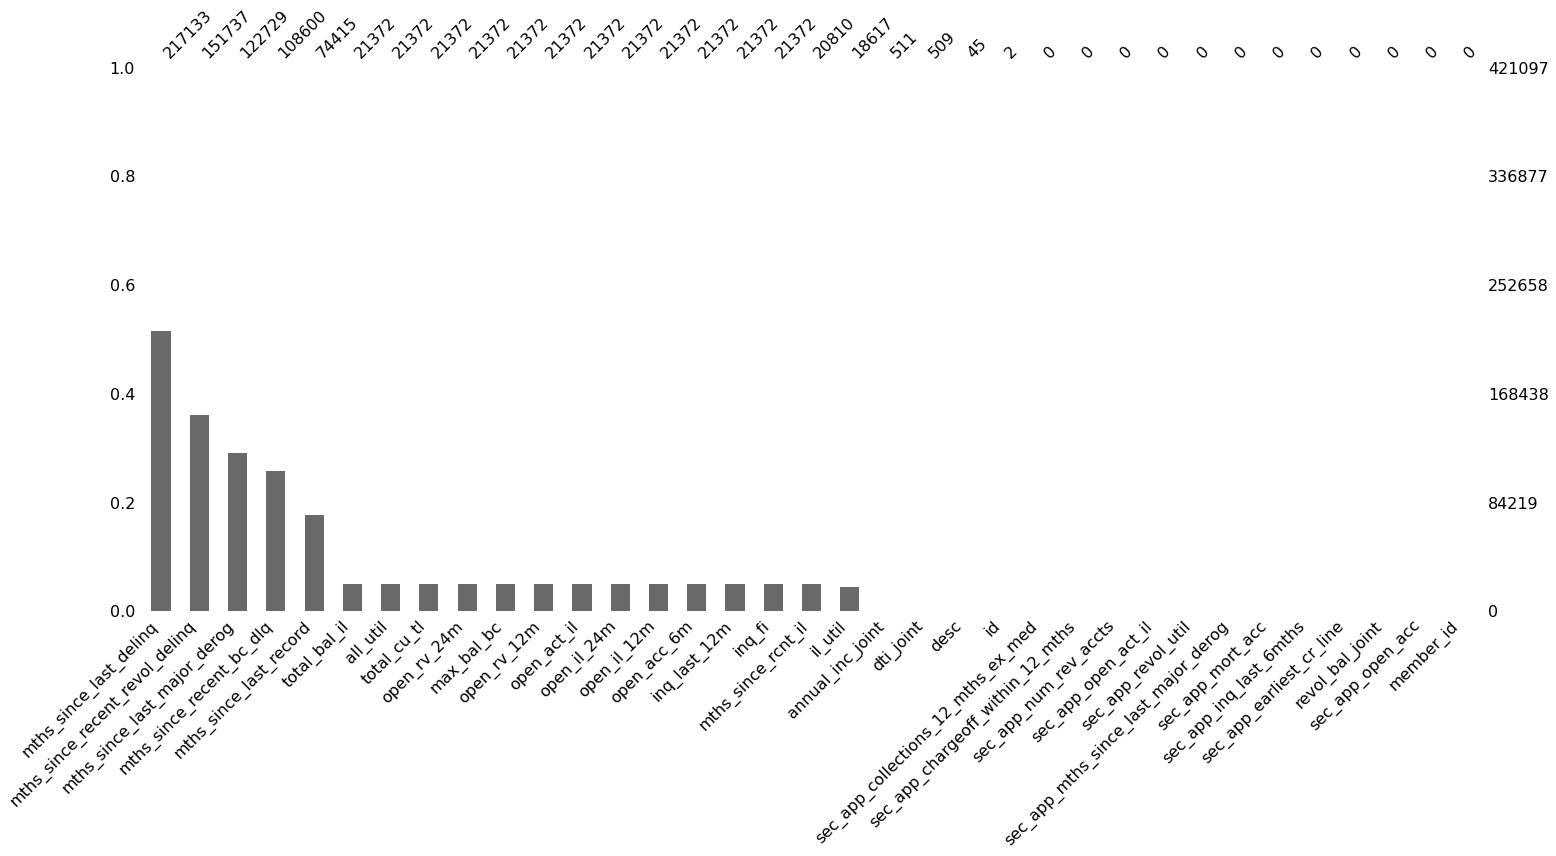

In [45]:
# bar chart to see missing visual in df3

import missingno as msno
msno.bar(df3.sample(421097))

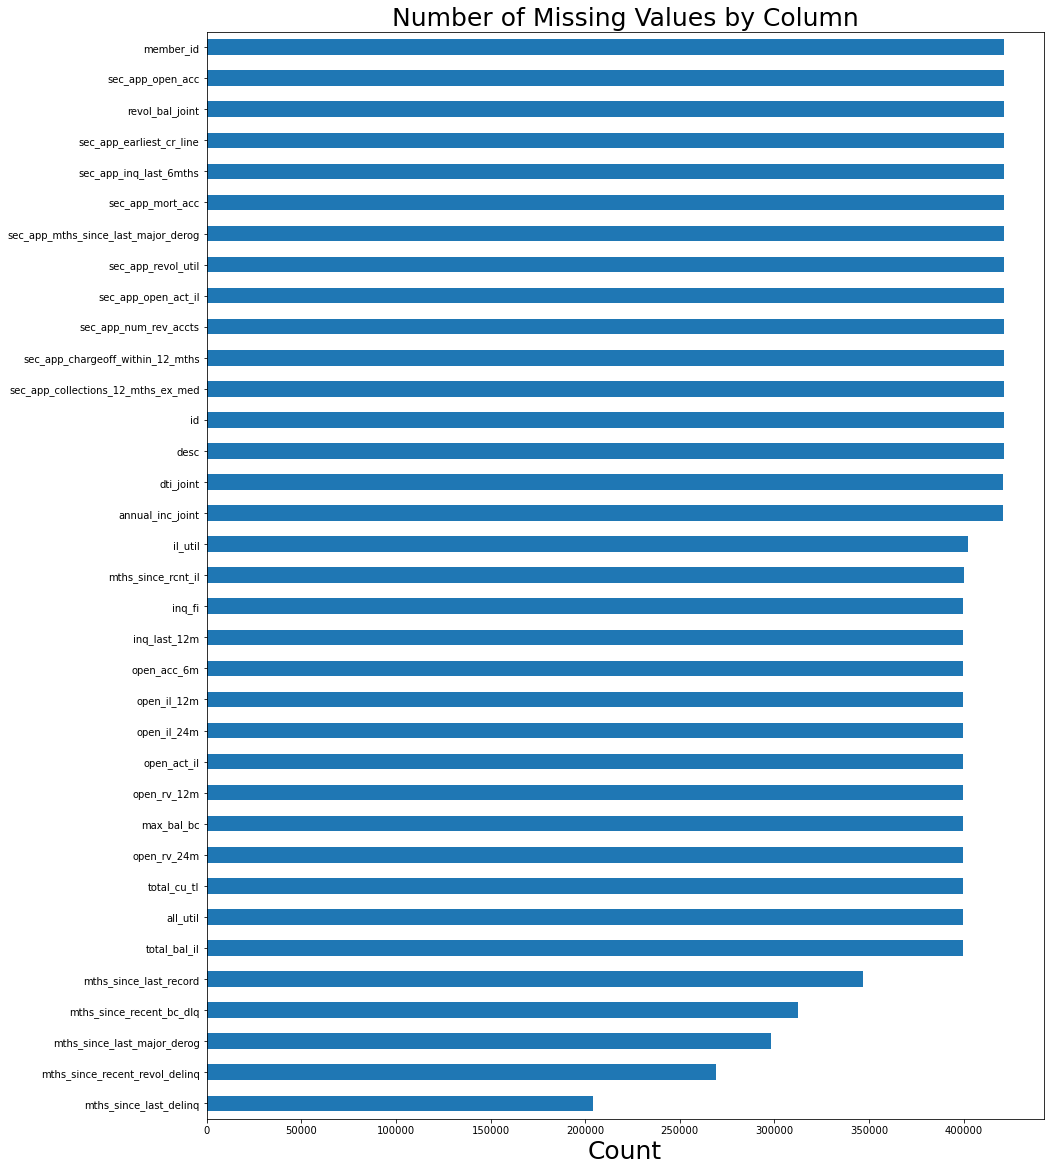

In [46]:
plt.figure(figsize = (15,20))
#df1.isnull().sum().sort_values().plot(kind = 'barh')
df3.isnull().sum().plot(kind = 'barh')
plt.title('Number of Missing Values by Column', size = 25)
plt.xlabel('Count', size = 25);

In [47]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421097 entries, 0 to 421096
Data columns (total 70 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   is_charged_off              421097 non-null  int64  
 1   open_acc                    421095 non-null  float64
 2   num_tl_op_past_12m          421095 non-null  float64
 3   num_tl_90g_dpd_24m          421095 non-null  float64
 4   num_tl_30dpd                421095 non-null  float64
 5   num_sats                    421095 non-null  float64
 6   num_rev_tl_bal_gt_0         421095 non-null  float64
 7   pct_tl_nvr_dlq              421095 non-null  float64
 8   num_op_rev_tl               421095 non-null  float64
 9   num_bc_tl                   421095 non-null  float64
 10  num_bc_sats                 421095 non-null  float64
 11  num_actv_bc_tl              421095 non-null  float64
 12  num_accts_ever_120_pd       421095 non-null  float64
 13  mort_acc      

In [48]:
# drop all null values in df2
df2 = df2.dropna()
df2.isnull().sum()

is_charged_off        0
open_acc              0
num_tl_op_past_12m    0
num_tl_90g_dpd_24m    0
num_tl_30dpd          0
                     ..
percent_bc_gt_75      0
mo_sin_old_il_acct    0
num_tl_120dpd_2m      0
emp_length            0
emp_title             0
Length: 70, dtype: int64

In [49]:
df2.shape

(365066, 70)

### b) Are there any glaringly erroneous data values?


-- columns around 35 are totally wrong because most of the data is missing


# what can me more here 

### Let’s build a model:

2) Using any format and any modeling technique that you prefer, please create a model to predict
charge off within the Lending Club dataset. Show any work that you would deem important in
evaluating this process and discuss some of the key features selected.

In [50]:
df2_numeric = df2._get_numeric_data()

In [51]:
df2_numeric.shape

(365066, 53)

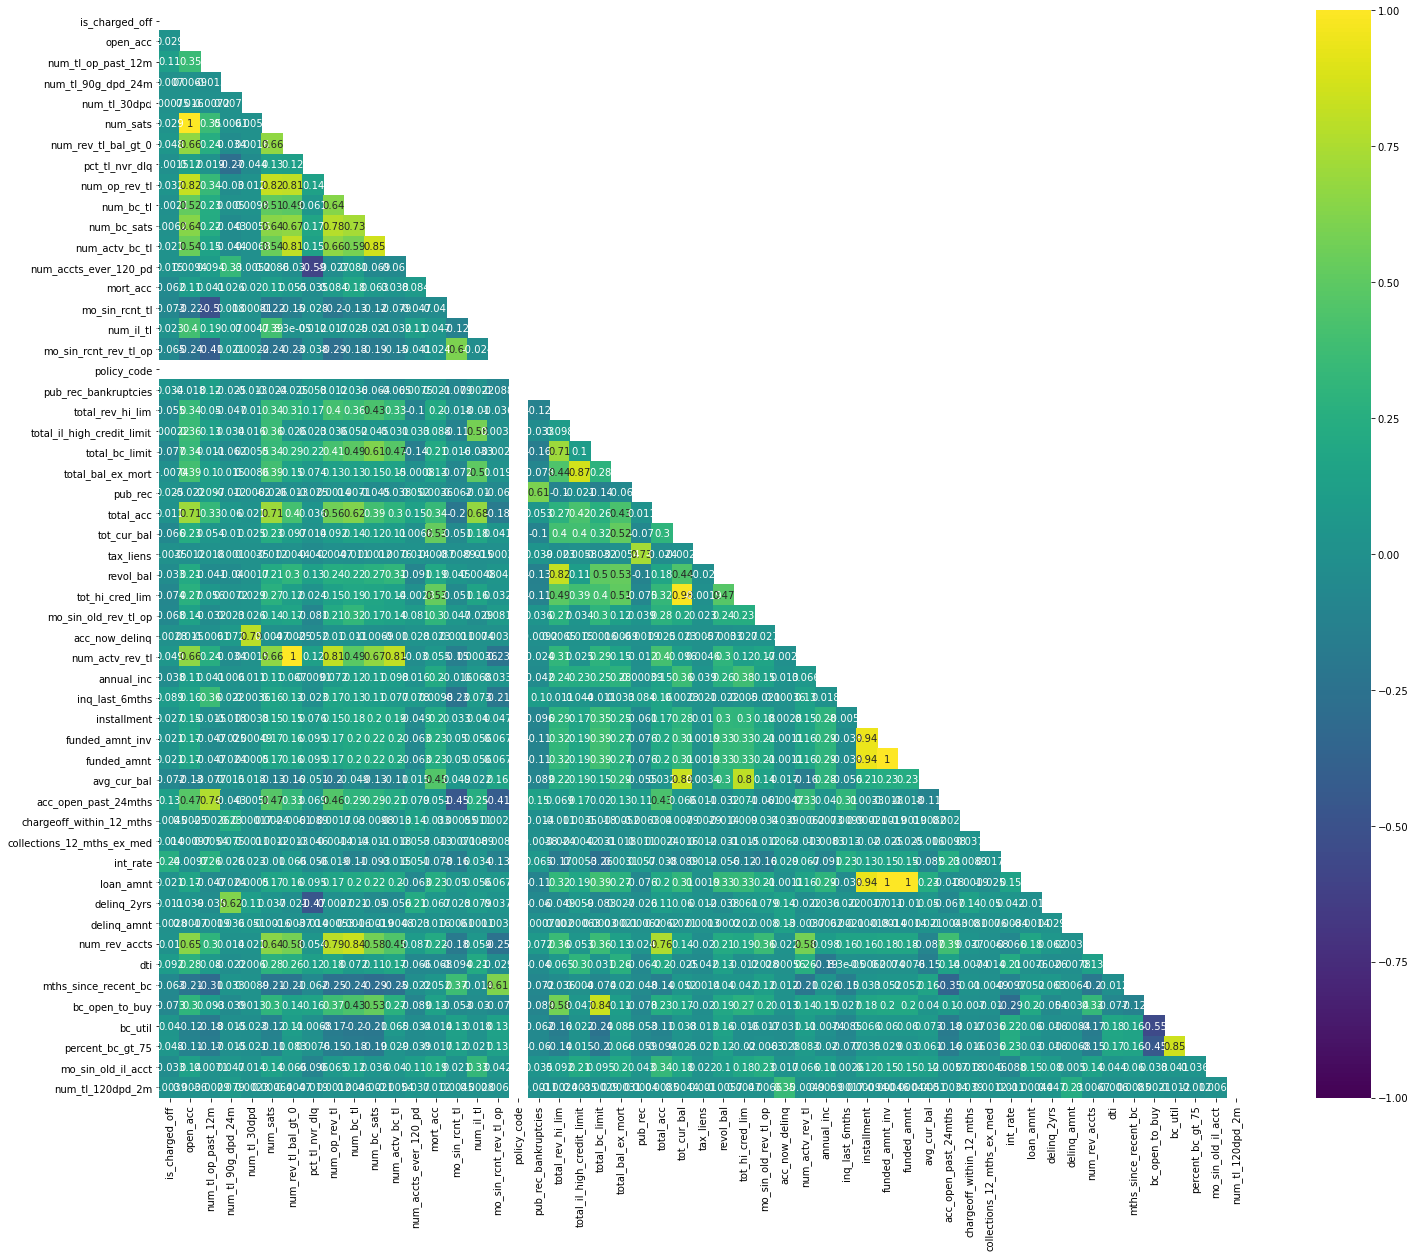

In [53]:

plt.figure(figsize=(25, 20))
mask = np.zeros_like(df2_numeric.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df2_numeric.corr(), mask = mask, square = True, cmap = 'viridis', annot = True, vmin=-1, vmax=1);

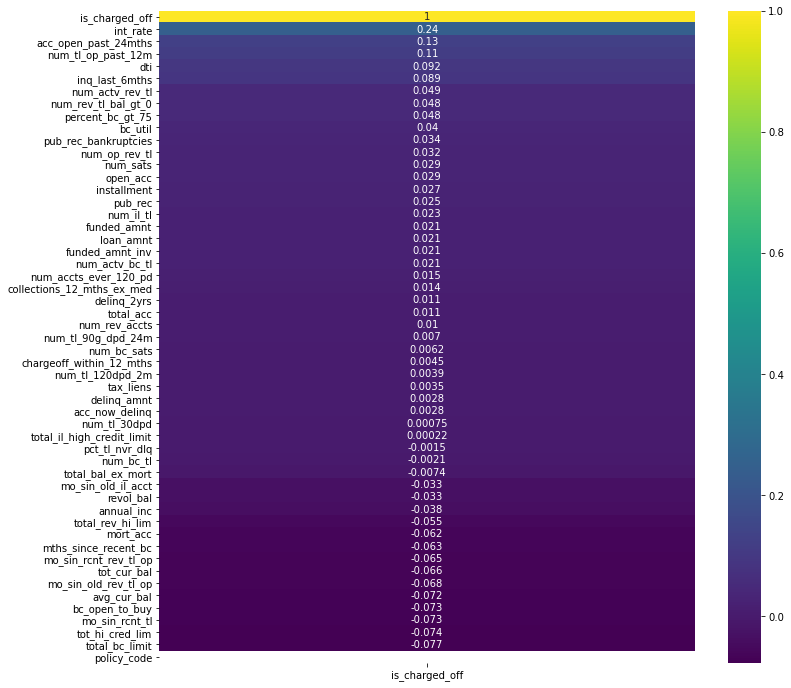

In [54]:
plt.figure(figsize=(12,12))

sns.heatmap(df2_numeric.corr()[['is_charged_off']].sort_values('is_charged_off', ascending=False), annot=True, cmap='viridis');

<AxesSubplot:>

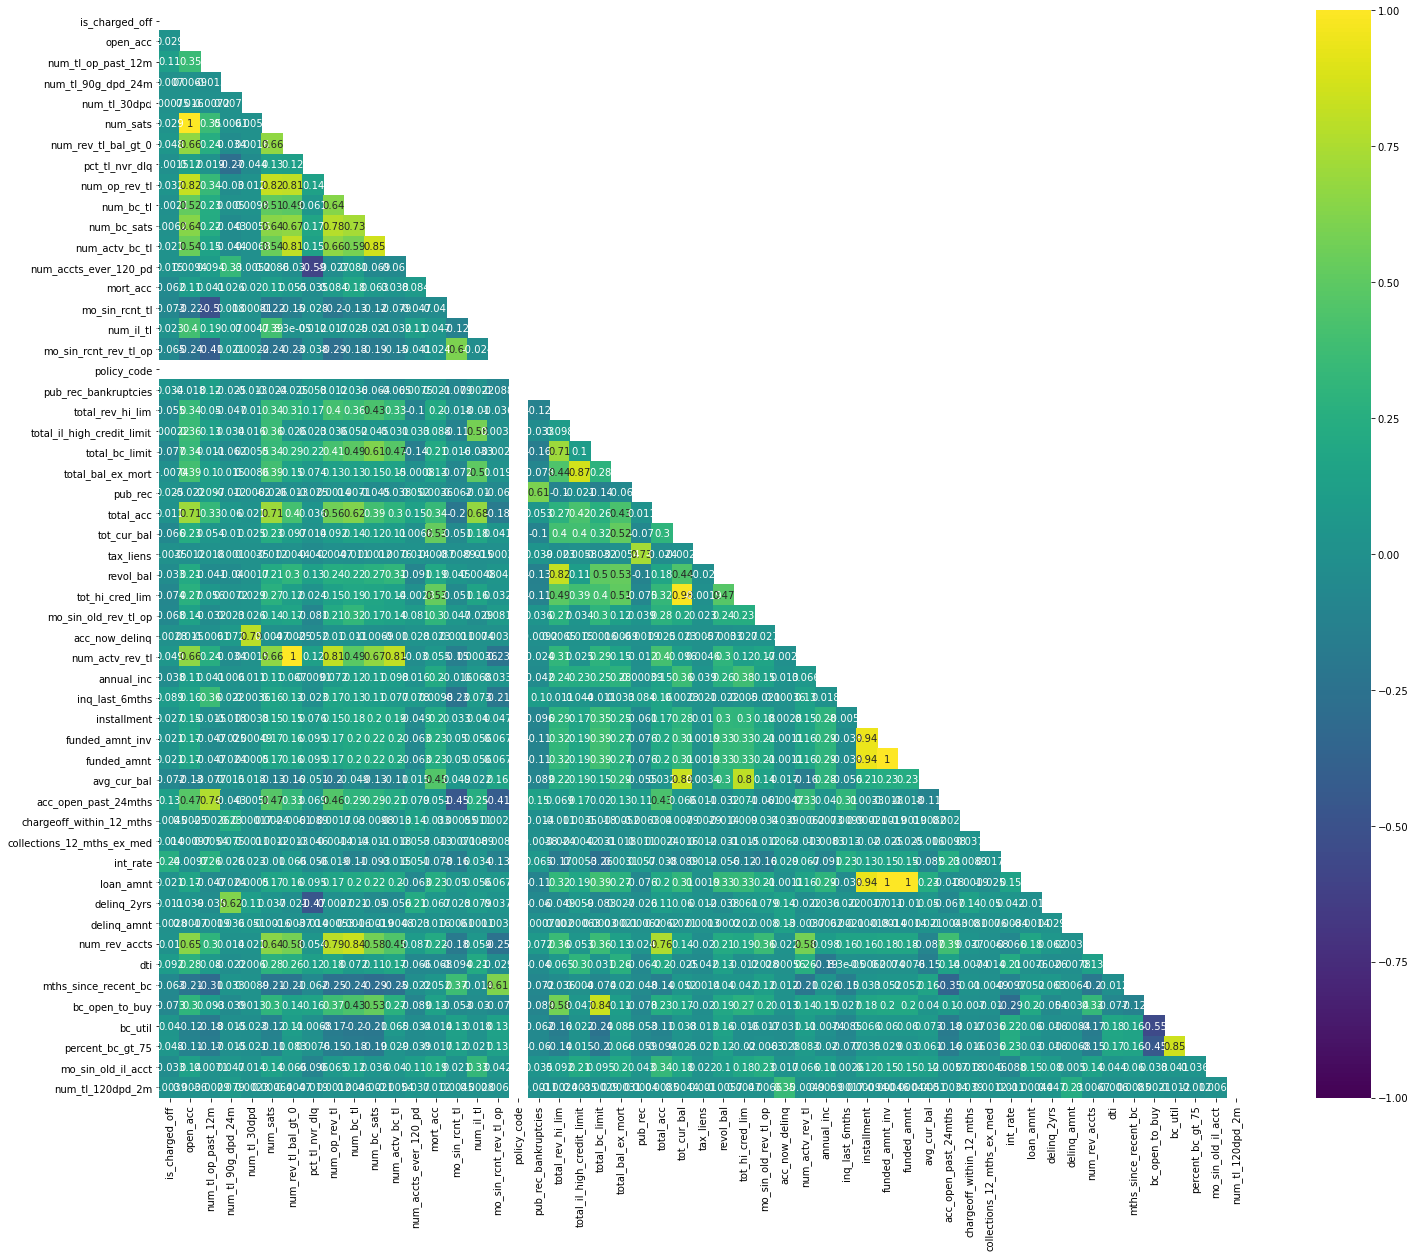

In [57]:
# Heatmap to see correlation of earning with other features.
plt.figure(figsize=(25, 20))
mask = np.zeros_like(df2.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df2.corr(), mask = mask, square = True, cmap = 'viridis', annot = True, vmin=-1, vmax=1)

In [58]:
df2_numeric['is_charged_off'].value_counts()

0    311117
1     53949
Name: is_charged_off, dtype: int64

In [59]:
df2_numeric.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [60]:
df2_numeric.columns

Index(['is_charged_off', 'open_acc', 'num_tl_op_past_12m',
       'num_tl_90g_dpd_24m', 'num_tl_30dpd', 'num_sats', 'num_rev_tl_bal_gt_0',
       'pct_tl_nvr_dlq', 'num_op_rev_tl', 'num_bc_tl', 'num_bc_sats',
       'num_actv_bc_tl', 'num_accts_ever_120_pd', 'mort_acc', 'mo_sin_rcnt_tl',
       'num_il_tl', 'mo_sin_rcnt_rev_tl_op', 'policy_code',
       'pub_rec_bankruptcies', 'total_rev_hi_lim',
       'total_il_high_credit_limit', 'total_bc_limit', 'total_bal_ex_mort',
       'pub_rec', 'total_acc', 'tot_cur_bal', 'tax_liens', 'revol_bal',
       'tot_hi_cred_lim', 'mo_sin_old_rev_tl_op', 'acc_now_delinq',
       'num_actv_rev_tl', 'annual_inc', 'inq_last_6mths', 'installment',
       'funded_amnt_inv', 'funded_amnt', 'avg_cur_bal', 'acc_open_past_24mths',
       'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'int_rate',
       'loan_amnt', 'delinq_2yrs', 'delinq_amnt', 'num_rev_accts', 'dti',
       'mths_since_recent_bc', 'bc_open_to_buy', 'bc_util', 'percent_bc_gt_75',


In [61]:
indep_features = df2_numeric[df2_numeric.columns[1:]] #df2[['num_rev_tl_bal_gt_0', 'num_op_rev_tl', 'num_bc_tl', 'num_bc_sats', 'num_actv_bc_tl', 'total_bc_limit', 'total_bal_ex_mort', 'total_acc', 'tax_liens', 'revol_bal', 'tot_hi_cred_lim', 'acc_now_delinq', 'num_actv_rev_tl', 'funded_amnt', 'avg_cur_bal', 'loan_amnt', 'num_rev_accts', 'mths_since_recent_bc', 'bc_open_to_buy', 'delinq_2yrs']]

In [62]:
indep_features.head()

,open_acc,num_tl_op_past_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_sats,num_rev_tl_bal_gt_0,pct_tl_nvr_dlq,num_op_rev_tl,num_bc_tl,num_bc_sats,...,delinq_2yrs,delinq_amnt,num_rev_accts,dti,mths_since_recent_bc,bc_open_to_buy,bc_util,percent_bc_gt_75,mo_sin_old_il_acct,num_tl_120dpd_2m
0,18.0,3.0,0.0,0.0,18.0,4.0,100.0,11.0,10.0,5.0,...,0.0,0.0,22.0,23.84,4.0,41055.0,17.1,0.0,127.0,0.0
1,7.0,1.0,0.0,0.0,7.0,1.0,100.0,4.0,3.0,3.0,...,0.0,0.0,7.0,9.54,73.0,24661.0,44.0,0.0,166.0,0.0
2,27.0,2.0,0.0,0.0,27.0,20.0,100.0,24.0,18.0,14.0,...,0.0,0.0,34.0,31.88,10.0,23476.0,59.9,50.0,143.0,0.0
3,9.0,3.0,0.0,0.0,9.0,2.0,95.7,4.0,7.0,3.0,...,0.0,0.0,11.0,18.50,16.0,21569.0,50.3,33.3,118.0,0.0
5,14.0,1.0,0.0,0.0,14.0,10.0,96.8,13.0,12.0,6.0,...,0.0,0.0,23.0,14.01,8.0,8302.0,75.0,33.3,156.0,0.0


In [63]:
# Step 1: Split into training & testing sets
y = df2_numeric['is_charged_off']
X = indep_features

In [64]:
X.shape

(365066, 52)

In [65]:
y.shape

(365066,)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [67]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [68]:
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [69]:
# Step 2: Instantiate our model.
logreg = LogisticRegression(solver='liblinear', class_weight={0:1, 1:6})

# Step 3: Fit our model.
# Fit model.
logreg.fit(X_train_ss, y_train)
logreg.score(X_train_ss, y_train),logreg.score(X_test_ss, y_test)

(0.6413135183108777, 0.6423789540578742)

In [70]:
# Get our scores
print('Cross val score:', cross_val_score(logreg, X_train_ss, y_train, cv=5).mean())

Cross val score: 0.6413463925752836


In [71]:
# Step 4 (part 1): Generate predicted values.
preds = logreg.predict(X_test_ss)

In [72]:
# Step 4 (part 2): Generate predicted probabilities.
logreg.predict_proba(X_test_ss)[0:10]

array([[0.23831151, 0.76168849],
       [0.8362073 , 0.1637927 ],
       [0.66596338, 0.33403662],
       [0.28462111, 0.71537889],
       [0.78565828, 0.21434172],
       [0.74525602, 0.25474398],
       [0.81880206, 0.18119794],
       [0.48522009, 0.51477991],
       [0.3387521 , 0.6612479 ],
       [0.64462588, 0.35537412]])

In [73]:
y.value_counts(normalize=True)

0    0.852221
1    0.147779
Name: is_charged_off, dtype: float64

In [74]:
# Step 5: Evaluate model.
logreg.score(X_train_ss, y_train) # Training Accuracy score

0.6413135183108777

In [75]:
# Step 5: Evaluate model (on testing).
logreg.score(X_test_ss, y_test) # Testing Accuracy score

0.6423789540578742

In [76]:
X_test_ss.shape

(91267, 52)

In [77]:
confusion_matrix(y_test, preds)

array([[49524, 28303],
       [ 4336,  9104]])

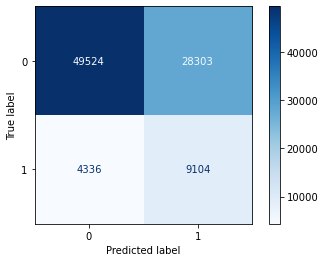

In [78]:
plot_confusion_matrix(logreg, X_test_ss, y_test, cmap='Blues', 
                      values_format='d', display_labels=['0', '1']);

In [79]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.92      0.64      0.75     77827
           1       0.24      0.68      0.36     13440

    accuracy                           0.64     91267
   macro avg       0.58      0.66      0.56     91267
weighted avg       0.82      0.64      0.69     91267



In [80]:
from sklearn.metrics import recall_score, precision_score

preds = logreg.predict(X_test_ss)
print('accuray:', logreg.score(X_test_ss, y_test))
print('recall:', recall_score(y_test, preds))
print('precision:', precision_score(y_test, preds))

accuray: 0.6423789540578742
recall: 0.6773809523809524
precision: 0.24337690806533538


In [81]:
# creating new data frame

y_preds_test = logreg.predict(X_test_ss)

cm = confusion_matrix(y_test, y_preds_test)
tn, fp, fn, tp = cm.ravel()

df_pred = pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])
df_pred

,Predicted 0,Predicted 1
Actual 0,49524,28303
Actual 1,4336,9104


In [82]:
# Save TN/FP/FN/TP values.

tn, fp, fn, tp = confusion_matrix(y_test, y_preds_test).ravel()

# Note that .ravel() will arrange items in a one-dimensional array.
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html

In [83]:
# Accuracy by hand
(tn + tp) / (tp + tn + fp + fn)

0.6423789540578742

In [86]:
# accuracy from the model
logreg.score(X_test_ss, y_test)

0.6423789540578742

In [87]:
# from sklearn metrics
accuracy_score(y_test, y_preds_test)

0.6423789540578742

In [88]:
# What is the test specificity of our model?
spec = tn / (tn + fp)
spec

0.6363344340652987

In [89]:
# sensitivity (recall) By hand
sens = tp / (tp + fn)
sens

0.6773809523809524

In [90]:
# sensitivity (recall) from sklearn
recall = recall_score(y_test, y_preds_test)
recall

0.6773809523809524

In [91]:
# precision By hand
tp / (tp + fp)

0.24337690806533538

In [92]:
# precision from sklearn
precision = precision_score(y_test, y_preds_test)
precision

0.24337690806533538

In [93]:
# F1 score by hand
2 * (precision*recall) / (precision+recall)

0.35809388951167226

In [94]:
# F1 score from sklearn
f1_score(y_test, y_preds_test)

0.35809388951167226

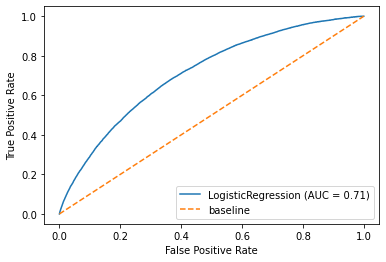

In [95]:
# ROC curve
# plt.figure(figsize=(4, 10))
plot_roc_curve(logreg, X_test_ss, y_test)

# add worst case scenario line
plt.plot([0, 1], [0, 1], label='baseline', linestyle='--')

# add a legend
plt.legend();

In [96]:
# Calculate ROC AUC.
roc_auc_score(y_test, logreg.predict_proba(X_test_ss)[:,1])

0.7134575802130121


### Interpreting ROC AUC
If you have an ROC AUC of 0.5, your 1 and 0  perfectly overlap and your model is as bad as it can get.

If you have an ROC AUC of 1, your 1 and 0 are perfectly separated and your model is as good as it can get. The closer your ROC AUC is to 1, the better. (1 is the maximum score.)

If you have an ROC AUC of below 0.5, your 1 and 0 distributions have flipped sides. By flipping your predicted values (i.e. flipping predicted 1s and 0s), your ROC AUC will now be above 0.5

Example: You have an ROC AUC of 0.2. If you change your predicted 1s to 0s and your predicted 0s to 1s, your ROC AUC will now be 0.8!

We generate one ROC curve per model. The ROC curve is generated by varying our threshold from 0 to 1. This doesn't actually change the threshold or our original predictions, but it helps us to visualize our tradeoff between sensitivity and specificity and understand how well-separated our charge-offs are.

### Model-2 Random Forest

In [102]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler

In [103]:
# Train test split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

In [104]:
# Instantiate and fit model
#class_weight={0:1, 1:6}
rf = RandomForestClassifier()
rf.fit(Z_train, y_train)

RandomForestClassifier()

In [105]:
# Get our scores
print('Cross val score:', cross_val_score(logreg, Z_train, y_train, cv=5).mean())
print('Training score:', rf.score(Z_train, y_train))
print('Testing score:', rf.score(Z_test, y_test))
from sklearn.metrics import recall_score, precision_score
rf_preds = rf.predict(X)
print('accuracy:', rf.score(X, y))
print('recall:', recall_score(y, rf_preds))
print('precision:', precision_score(y, rf_preds))
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)
from sklearn.metrics import confusion_matrix

Cross val score: 0.6413463925752836
Training score: 0.9999926953714221
Testing score: 0.8530794262986622
accuracy: 0.3228786027731972
recall: 0.794379877291516
precision: 0.1536294124184014


In [106]:
# creating new data frame
rf_preds_test = rf.predict(Z_test)
cm = confusion_matrix(y_test, rf_preds_test)
tn, fp, fn, tp = cm.ravel()
df_pred_2 = pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])
df_pred_2

,Predicted 0,Predicted 1
Actual 0,77708,119
Actual 1,13290,150


## Model-3: Regularization with LASSO

In [108]:
from sklearn.linear_model import LogisticRegressionCV

In [109]:
logreg_cv = LogisticRegressionCV(Cs=10, cv=5, penalty="l1", solver="liblinear")
logreg_cv.fit(X_train_ss, y_train)

print(logreg_cv.score(X_train_ss, y_train))
print(logreg_cv.score(X_test_ss, y_test))

0.8520484004689571
0.8527397635509001


In [110]:
preds_cv = logreg_cv.predict(X_test_ss)


In [111]:
confusion_matrix(y_test, preds_cv)

array([[77827,     0],
       [13440,     0]])

In [112]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds_cv))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     77827
           1       0.00      0.00      0.00     13440

    accuracy                           0.85     91267
   macro avg       0.43      0.50      0.46     91267
weighted avg       0.73      0.85      0.78     91267



/Users/tahir/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Section C
3) Please choose one of the topics below and concisely explain it to:

a) Someone with significant mathematical experience.

b) Someone with little mathematical experience.

c) Topics: Logistic Regression, Principal Component Analysis, Factor Analysis, Markov
Process, Hidden Markov Models, Gradient Boosted Trees, Survival Modeling, Kernel
Density Estimation, or the Curse of Dimensionality.

### a) Someone with significant mathematical experience.

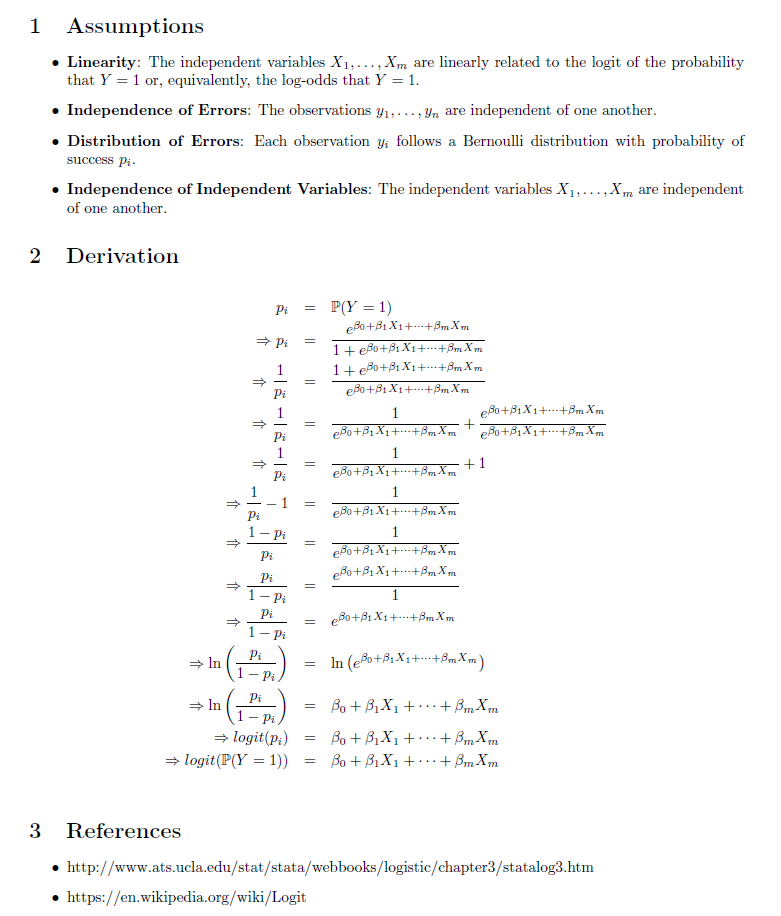

### b) Someone with little mathematical experience.

Logistic Regression: This method uses math to evaluate the chances of something happening or not. It allows us to answer any “yes or no” questions. In other words male or female and spam or no-spam emails.

The major assumption used here are given in above math section

Logistic Regression can be either binary or multinomial. However, here our system is binary (charge-off , not) == (1,0) and let us focus on the binary version for now.

Statistical goodness of fit is based on the Chi-square test and the test shows significant difference.

Based on some factors, the machine weighs the probabilities of each email being spam or not. Depending on these probabilities of it belonging to either class, a decision can be made on if it is a spam email or not spam email.